# Texas is Ripe for Solar Power
- I was approached by 
[Aim]
[Evidence]
[Conclusion]

### To-Do:
- include number of distinct solar companies operating in each state

### Data Issues:
- Instances of '.' in avg_cents_per_kWh replaced with None.
- Removed entity rows "Adjustment 2021" (1484:1534)

In [1]:
### Setup ###
from csv import reader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statistics as stat
from pandasql import *
elec_filepath = "/Users/zachpolitz/Desktop/state_electricity_table6.csv"
pop_filepath = "/Users/zachpolitz/Desktop/cleaned_US_pop_2021.csv"


### Population file ###
P_opened = open(pop_filepath)
P_read_csv = pd.read_csv(P_opened)
Population_raw = pd.DataFrame(P_read_csv)

### Functional Status Code Counts###
f_stat = Population_raw["FUNCSTAT"].unique()
fstat_counts = sqldf("""
SELECT "FUNCSTAT", COUNT("FUNCSTAT")
FROM Population_raw
GROUP BY "FUNCSTAT"
""", globals())
### Geographic Summary Level Counts ###
SUMLEVs = Population_raw['SUMLEV'].unique()
SUMLEV_counts = sqldf("""
SELECT "SUMLEV", COUNT("SUMLEV")
FROM Population_raw
GROUP BY "SUMLEV"
""", globals())

### Extract distinct places ###
places = Population_raw['PLACE'].unique()
### Extract county populations ###
county_us_populations = sqldf("""
SELECT *
FROM Population_raw
WHERE "NAME" NOT LIKE "STNAME" AND
"FUNCSTAT" LIKE "A" AND
"NAME" LIKE "% county"
""", globals())
### Extract city populations ###
city_us_populations = sqldf("""
SELECT "NAME","STNAME","POPESTIMATE2021"
FROM Population_raw
WHERE "NAME" NOT LIKE "STNAME" AND
"FUNCSTAT" LIKE "A" AND
"NAME" LIKE "% city"
""", globals())
### Extract state total populations ###
state_us_populations = sqldf("""
SELECT "STNAME","POPESTIMATE2021"
FROM Population_raw
WHERE "NAME" LIKE "STNAME"
""", globals())
### Change population estimates from strings to integers ###
county_us_populations['POPESTIMATE2021'] = county_us_populations['POPESTIMATE2021'].astype(int)
state_us_populations['POPESTIMATE2021'] = state_us_populations['POPESTIMATE2021'].astype(int)
city_us_populations['POPESTIMATE2021'] = city_us_populations['POPESTIMATE2021'].astype(int)


### Open electricity file ###
E_opened = open(elec_filepath)
E_read_csv = pd.read_csv(E_opened)
Electricity_raw = pd.DataFrame(E_read_csv)
### rename Electricity_raw, columns, then drop unused rows ###
electric_cols = ['entity','state','ownership','customer_count','sales_Megawatthours','revenue_thousands_dollars','avg_cents_per_kWh']
Electricity_raw.columns = electric_cols
us_elec = Electricity_raw[2:].copy()
### Clean us_elec ###
# remove ',' and '.' from cells (avg_cents_per_kWh), 
# convert dtypes to float
# remove entity instances of "Adjustment 2021" (rows above index 1483)
for col in electric_cols[3:]:
    d = us_elec[col]
    for r in range (0,len(d)):
        cell = d.iloc[r]    
        if type(cell) == str:
            if cell == '.':
                d.iloc[r] = None
            else:
                cell_cleaned = cell.replace(',','')
                cell_as_float = float(cell_cleaned)
                d.iloc[r] = cell_as_float
    us_elec.loc[col] = d    
us_elec = us_elec.iloc[:1483].copy()


### Table parameters
pd.options.display.max_rows = 10000
pd.options.display.max_columns = 15


### State Abbreviation Dictionary ###
state_abvs = {
'AK':'Alaska','AL':'Alabama','AR':'Arkansas',
'AZ':'Arizona','CA':'California','CO':'Colorado','CT':'Connecticut',
'DC': 'District of Columbia','DE':'Deleware','FL':'Florida','GA':'Georgia',
'HI': 'Hawaii','IA':'Iowa','ID':'Idaho','IL':'Illinois',
'IN':'Indiana','KS':'Kansas','KY':'Kentucky','LA':'Louisiana',
'MA':'Massachussets','MD':'Maryland','ME':'Maine','MI':'Michigan',
'MN':'Minnesota','MO':'Missouri','MS':'Mississippi','MT':'Montana',
'NC':'North Carolina','ND':'North Dakota','NE':'New England','NH':'New Hampshire',
'NJ':'New Jersey','NM':'New Mexico','NV':'Nevada','NY':'New York',
'OH':'Ohio','OK':'Oklahoma','OR':'Oregon','PA':'Pennsylvania',
'RI':'Rhode Island','SC':'South Carolina','SD':'South Dakota','TN':'Tennessee',
'TX':'Texas','UT':'Utah','VA':'Virginia','VT':'Vermont',
'WA':'Washington','WI':'Wisconsin','WV':'West Virginia','WY':'Wyoming'}

### Population Census Explanations 
Population Data: https://www.census.gov/data/developers/data-sets/popest-popproj/popest/popest-vars.html


FUNCSTAT: Functional Status Code
- A = identifies an active government providing primary general-purpose functions
- B = identifies an active government that is partially consolidated with another government but with separate officials providing primary general-purpose functions
- C = identifies an active government consolidated with another government with a single set of officials
- F = identifies a fictitious entity created to fill the Census Bureau's geographic hierarchy
- G = identifies an active government that is subordinate to another unit of government
- I = identifies an inactive governmental unit that has the power to provide primary special-purpose functions
- N = identifies a nonfunctioning legal entity
- S = identifies a statistical entity

SUMLEV: Geographic Summary Level
- 010 = Nation
- 020 = Region
- 030 = Division
- 040 = State and/or Statistical Equivalent
- 050 = County and/or Statistical Equivalent
- 061 = Minor Civil Division
- 071 = Minor Civil Division place part
- 157 = County place part
- 162 = Incorporated place
- 170 = Consolidated city
- 172 = Consolidated city -- place within consolidated city
- 310 = Metropolitan Statistical Area/Micropolitan Statistical Area
- 314 = Metropolitan Division
- 330 = Combined Statistical Area

### Electricity Data Explanations
- "2021 Utility Bundled Sales to Ultimate Customers- Residential
- Data from forms EIA-861- schedules 4A & 4D and EIA-861S)"


In [7]:
# Rank order electricity entity ownership types by volume of customers.
# Aggregate other columns for each entity type
ownership_summary = sqldf("""
SELECT "ownership" AS "Owndership Type", 
        COUNT("ownership") AS "Entities", 
        SUM("customer_count") AS "Customers", 
        SUM("sales_Megawatthours") as "Megawatt Hours Sold",
        SUM("revenue_thousands_dollars"),
        AVG("avg_cents_per_kWh") FROM us_elec
GROUP BY "ownership"
ORDER BY "Megawatt Hours Sold" DESC
""", globals())

ownership_summary

,Owndership Type,Entities,Customers,Megawatt Hours Sold,"SUM(""revenue_thousands_dollars"")","AVG(""avg_cents_per_kWh"")"
0,Investor Owned,187,79844960.0,799834492.0,111383360.1,14.359733
1,Cooperative,623,17362604.0,234139133.0,28274824.1,12.769567
2,Municipal,455,12717117.0,135448137.0,16330486.7,11.824044
3,Retail Power Marketer,65,6614852.0,87105885.0,11064036.2,11.811385
4,Political Subdivision,49,3536659.0,44496986.0,5096361.9,10.956939
5,State,8,1241819.0,11894223.0,2377503.2,13.172500
6,Behind the Meter,94,983740.0,8259075.0,1408157.5,NaN
7,Federal,2,26504.0,364934.0,29933.2,8.890000


In [8]:
# What does "behind the meter" mean?
# - Entities are solar companies.

behind_the_meter = sqldf("""
SELECT * FROM us_elec
WHERE "ownership" LIKE "Behind the Meter"
ORDER BY "state"
""", globals())

#behind_the_meter

In [9]:
# Do only "behind the meter" entities report 0 "avg cents per kWh"?
# - print unique ownership types for values of 0 and null.
# Answer: "behind the meter" will not include "avg cents per kWh".

non_behind_the_meter = sqldf("""
SELECT * FROM us_elec
WHERE "avg_cents_per_kWh" = 0
""", globals())
print("zero values: ", non_behind_the_meter['ownership'].unique()) # no instances of 0 

zero_avkWh = sqldf("""
SELECT * FROM us_elec
WHERE "avg_cents_per_kWh" ISNULL
""", globals())
print("unique  null values: ", zero_avkWh['ownership'].unique()) # Null values are all "behind the meter"


zero values:  []
unique  null values:  ['Behind the Meter']


## Digging into Tasks

In [11]:
# Extract the summed solar data for each state
solar_per_state = sqldf("""
SELECT "state", COUNT("entity") AS "solar companies", SUM("customer_count"), SUM("sales_Megawatthours"), SUM("revenue_thousands_dollars")  FROM us_elec
WHERE "ownership" LIKE "Behind the Meter"
GROUP BY "state"
""", globals())

# Convert state name abbreviations to full state name
for i in range (0,len(solar_per_state)):
    x = solar_per_state.iloc[i].copy()
    n = x["state"]
    x["state"] = state_abvs[n]
    solar_per_state.iloc[i] = x

# Join state population and solar data tables, and order by population size
state_pop_elec = sqldf("""
SELECT * FROM state_us_populations
INNER JOIN solar_per_state
ON state_us_populations.STNAME = solar_per_state.state
ORDER BY "POPESTIMATE2021" DESC
""", globals())

# Drop extra column generated during join
state_pop_elec.drop(state_pop_elec.columns[2],axis = 1,inplace = True)


In [12]:
state_pop_elec

,STNAME,POPESTIMATE2021,solar companies,"SUM(""customer_count"")","SUM(""sales_Megawatthours"")","SUM(""revenue_thousands_dollars"")"
0,California,39237836,5,447012.0,3474313.0,690511.9
1,Texas,29527941,3,14920.0,152337.0,20590.6
2,Florida,21781128,3,6869.0,82646.0,11733.3
3,New York,19835913,5,65231.0,466832.0,89072.1
4,Pennsylvania,12964056,4,15183.0,138355.0,20595.1
5,Illinois,12671469,3,11992.0,116375.0,11350.0
6,North Carolina,10551162,1,1.0,5.0,0.3
7,New Jersey,9267130,5,78748.0,636382.0,104527.0
8,Virginia,8642274,1,66.0,310.0,23.0
9,Washington,7738692,2,100.0,613.0,79.5


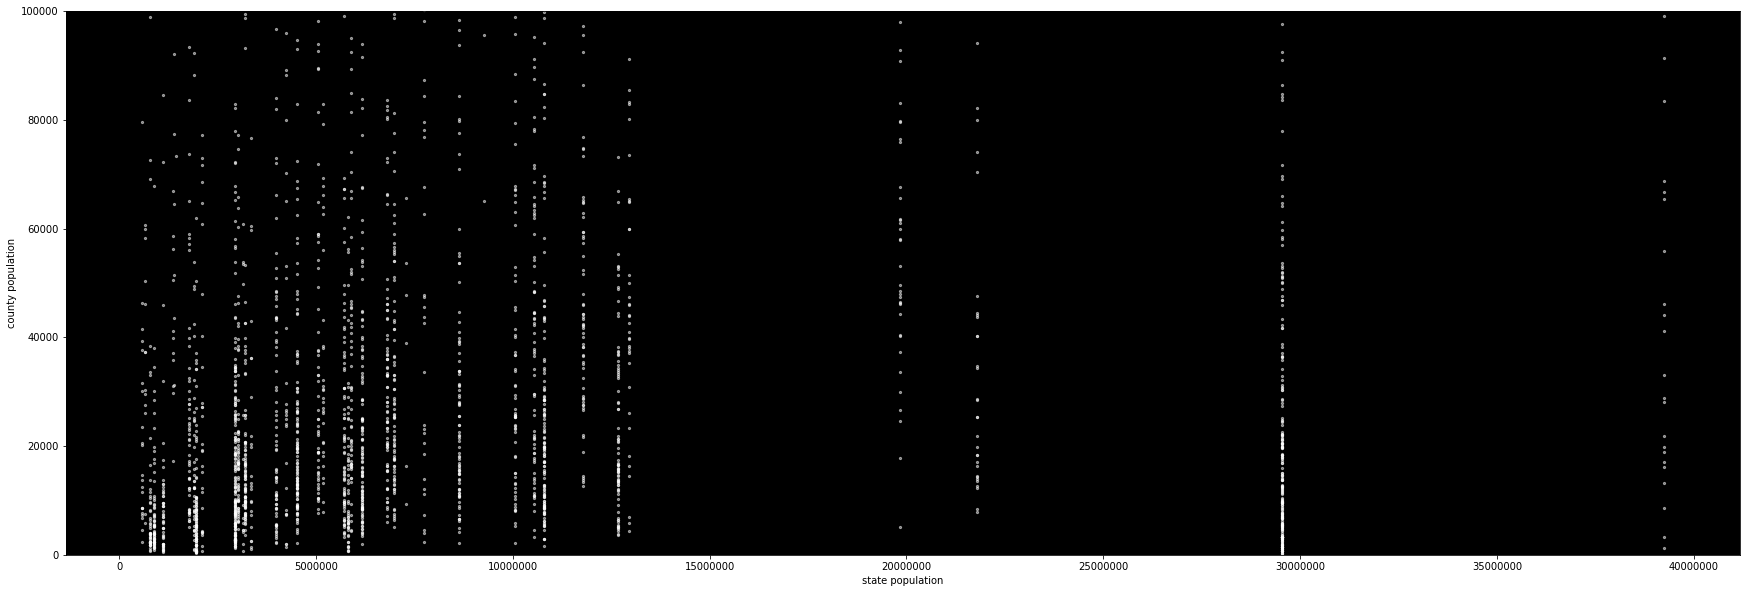

In [13]:
### explore population densities of states
popu = county_us_populations.copy()
POPU = state_us_populations.copy()
POPU = POPU.drop(axis=1,index= 8)
STs = popu["STNAME"].unique()
cty_pops = []
st_pops = []

for s in STs:
    p_ct = popu[popu["STNAME"] == s].copy()
    p_st = POPU[POPU["STNAME"] == s].copy()
    p_parameter = int(p_st['POPESTIMATE2021'])
    # print(p_parameter,s)
    for r in range(0, len(p_ct)):
        d = p_ct.iloc[r]
        x = d['POPESTIMATE2021']
        cty_pops.append(float(x))
        st_pops.append(int(p_parameter))


### visualize counties less than 100,000
fig, ax = plt.subplots()
fig.set_figwidth(30)
fig.set_figheight(10)

ax.set_ylim(0,100000)
ax.ticklabel_format(style='plain')
ax.set_ylabel("county population")
ax.set_xlabel("state population")
ax.set_facecolor("black")
ax.scatter(st_pops, cty_pops,c='white', s = 5, alpha = .5)

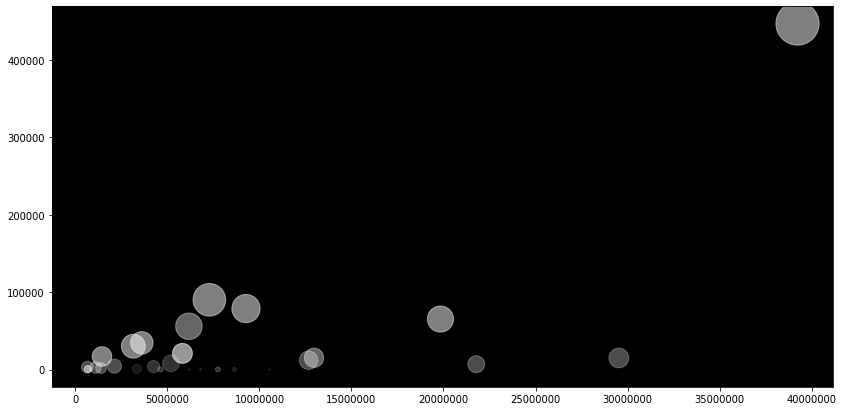

In [14]:
fig, ax = plt.subplots()
fig.set_figwidth(14)
fig.set_figheight(7)

ax.ticklabel_format(style='plain')
ax.set_facecolor("black")

ax.scatter(state_pop_elec['POPESTIMATE2021'],
            state_pop_elec['SUM("customer_count")'], 
            s = state_pop_elec['SUM("sales_Megawatthours")']**.5,
            c = "white",
            alpha = state_pop_elec['solar companies']/10)

## Conclusion: Texas and Florida are ripe for solar.
- Texas and Florida are the second and third largest states, coming in at ~30 and ~20 million people, respectively.
- Texas and Florida have only 3 solar power providers, as of 2021.
- However, they only have 10-15 thousand electricity providers that are "behind the meter".
- ’Behind the meter' is power produced and consumed on-site. Residential solar is a common example. Solar panels generate electricity, which is fed into the home for use.

### Continuing Curiosities:
- How do things like hurricanes impact solar panels? Would this disincentivise affected areas in Florida?
- Texas has great access to direct sunlight, major recent issues with their grid, but low acceptance. What's the holdup? Politics? Access? Logistics?